## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Install Required Libraries

In [60]:
# Install datasets and transformers libraries
!pip install datasets transformers

In [3]:
# Install necessary libraries
!pip install transformers datasets torch sklearn

# Now, import the necessary modules
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# The rest of your code for loading data, tokenization, model training goes here


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Load Dataset

In [4]:
# Load the phishing email dataset from Google Drive
df = pd.read_csv("/content/gdrive/MyDrive/nlp/Phishing_Email.csv")

## Data Cleaning

In [5]:
# Drop rows where 'Email Text' or 'Email Type' is missing
df.dropna(subset=['Email Text', 'Email Type'], inplace=True)

## Label Encoding

In [6]:
# Encode email types into binary labels for classification
df['label'] = df['Email Type'].apply(lambda x: 1 if x == 'Phishing Email' else 0)

## Balance Dataset

In [7]:
# Count the instances of each class to balance them
count_class_0, count_class_1 = df['label'].value_counts()
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

In [8]:
df_class_0_under = df_class_0.sample(count_class_1)
df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)

## Display Balanced Data

In [9]:
# Display counts of each class after balancing
print('Random under-sampling:')
print(df_balanced['label'].value_counts())

Random under-sampling:
label
0    7312
1    7312
Name: count, dtype: int64


## Reduce and Split Dataset

In [10]:
# Reduce the dataset size to 10% of the original and split into training and testing sets
df_reduced = df_balanced.sample(frac=0.1)  # Reduce to 50% of the balanced dataset

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df_reduced, test_size=0.2, random_state=42)

## Data Exploration

In [11]:
# Display top rows in the reduced dataframe
df_reduced.head()

,Unnamed: 0,Email Text,Email Type,label
17243,17244,"hpl nom for january 11 , 2001 ( see attached f...",Safe Email,0
10736,10737,NEWSLETTER COACHÂ’INVEST Â– SEPTEMBRE 2002Coac...,Phishing Email,1
5209,5209,the only fix to penis growth limited time offe...,Phishing Email,1
11730,11731,re [ 8 ] : other guys are improving themselves...,Phishing Email,1
15789,15790,alden metallic supervifagra - ciaylis take it ...,Phishing Email,1


In [12]:
# Count null values in the dataset
df_reduced.isnull().sum()

Unnamed: 0    0
Email Text    0
Email Type    0
label         0
dtype: int64

In [13]:
# Descriptive statistics for the dataset
df.describe()

,Unnamed: 0,label
count,18634.000000,18634.000000
mean,9328.282226,0.392401
std,5384.237476,0.488298
min,0.000000,0.000000
25%,4666.250000,0.000000
50%,9329.500000,0.000000
75%,13991.750000,1.000000
max,18650.000000,1.000000


## Visualization

In [14]:
# Print top rows and value counts of email texts
print(df_reduced.head())
print(df_reduced['Email Text'].value_counts())

       Unnamed: 0                                         Email Text  \
17243       17244  hpl nom for january 11 , 2001 ( see attached f...   
10736       10737  NEWSLETTER COACHÂ’INVEST Â– SEPTEMBRE 2002Coac...   
5209         5209  the only fix to penis growth limited time offe...   
11730       11731  re [ 8 ] : other guys are improving themselves...   
15789       15790  alden metallic supervifagra - ciaylis take it ...   

           Email Type  label  
17243      Safe Email      0  
10736  Phishing Email      1  
5209   Phishing Email      1  
11730  Phishing Email      1  
15789  Phishing Email      1  
Email Text
empty                                                                                                                                                                                                                                                                                                                                                                             

<Axes: xlabel='label', ylabel='count'>

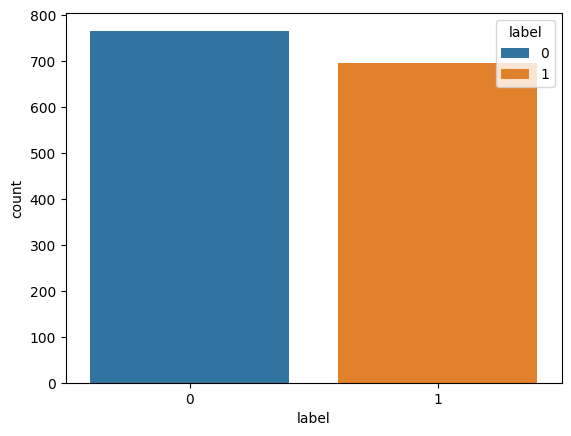

In [15]:
# Visualize the distribution of the labels
import seaborn as sns
target = df_reduced['label']
sns.countplot(x=target, hue=target)

## Prepare Datasets for Training

In [16]:
# Convert pandas DataFrames to Hugging Face dataset objects
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

## Tokenizer Initialization

In [17]:
# Load and prepare the DistilBert tokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Tokenization Function

In [26]:
# Define the tokenization function for processing text data
def tokenize_function(examples):
    return tokenizer(examples['Email Text'], padding="max_length", truncation=True, max_length=512)

## Apply Tokenization

In [27]:
# Tokenize the training and testing datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1169 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## Model Initialization

In [20]:
# Load the DistilBert model prepared for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setup Acceleration and Verify

In [21]:
# Install and update the transformers and accelerate libraries
pip install transformers[torch]

In [22]:
pip install accelerate -U

In [23]:
# Import and check the version of accelerate to ensure it's correctly installed
import accelerate
print(accelerate.__version__)

0.30.0


## Train and Save Model

In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {'accuracy': ((np.argmax(p.predictions, axis=1) == p.label_ids).mean())}
)


In [30]:
# Train the model and save it to Google Drive
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.147606,0.945392
1,No log,0.167924,0.952218
2,No log,0.197048,0.945392
4,No log,0.201390,0.955631
5,No log,0.215987,0.955631
6,No log,0.228796,0.955631
8,No log,0.236564,0.952218
9,No log,0.240454,0.955631
10,No log,0.243587,0.955631
12,No log,0.247890,0.955631


## Save Model and Tokenizer

In [37]:
model.save_pretrained('/content/gdrive/MyDrive/nlp/model')
tokenizer.save_pretrained('/content/gdrive/MyDrive/nlp/model')

('/content/gdrive/MyDrive/nlp/model/tokenizer_config.json',
 '/content/gdrive/MyDrive/nlp/model/special_tokens_map.json',
 '/content/gdrive/MyDrive/nlp/model/vocab.txt',
 '/content/gdrive/MyDrive/nlp/model/added_tokens.json')

## Evaluate and Visualize Model Performance

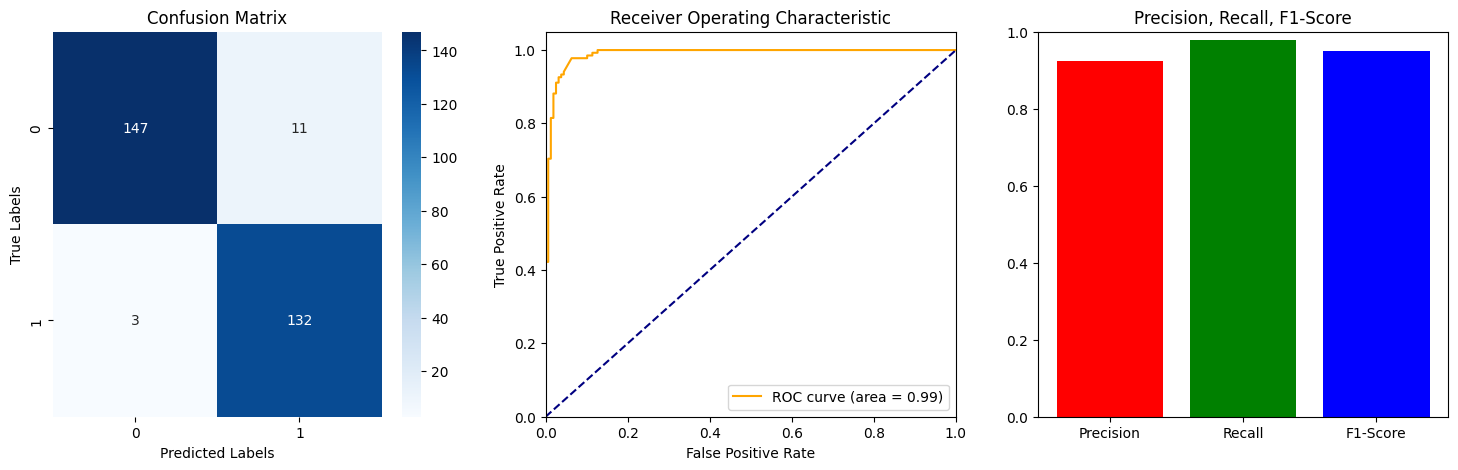

In [31]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'test_dataset' is available and has been processed through the model
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Metrics
precision, recall, fscore, _ = precision_recall_fscore_support(test_dataset['label'], pred_labels, average='binary')

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_dataset['label'], predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

# Confusion Matrix
cm = confusion_matrix(test_dataset['label'], pred_labels)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# ROC Curve
axes[1].plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')
axes[1].legend(loc="lower right")

# Bar chart for Precision, Recall, and F1-Score
bars = axes[2].bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, fscore], color=['red', 'green', 'blue'])
axes[2].set_title('Precision, Recall, F1-Score')
axes[2].set_ylim([0, 1])

plt.show()


In [44]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the tokenizer and model
model_test_path = '/content/gdrive/MyDrive/nlp/model'
tokenizer_test = DistilBertTokenizer.from_pretrained(model_test_path)
model_test = DistilBertForSequenceClassification.from_pretrained(model_test_path)


In [46]:
model_test.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [56]:
def prepare_data(texts):
    # Tokenize the texts
    encoded_batch = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    return encoded_batch

# Example texts id = 20, safe email; id = 8, phishing email
texts = ["re : meeting on feb 8 , 2001 dear mr . nur azmin abu bakar , thanks for your prompt reply . please , let us know how many members of your team will visit enron . i look forward to our meeting on february 8 . vince kaminski azminab @ petronas . com . my on 01 / 02 / 2001 06 : 38 : 33 pm to : vince . j . kaminski @ enron . com , khairuddinbmjaafar @ petronas . com . my , shirley . crenshaw @ enron . com cc : subject : re : meeting on feb 8 , 2001 dear kaminski , happy new year and thank you for the reply . we are honored to have lunch with you and your team however we have another appointment at 2 . 30 p . m . regards vince . j . kaminski @ enron . com on 03 / 01 / 2001 07 : 38 : 19 am to : azminab @ petronas . com . my cc : vince . j . kaminski @ enron . com , shirley . crenshaw @ enron . com subject : meeting on feb 8 , 2001 dear sir , i would like to apologize for the delay in responding to your fax . i was on vacation for the last few days . i shall be honored to meet your delegation on thursday , february 8 at 10 : 00 a . m . please , let me know if you will be free for lunch after the meeting . vince kaminski", "we owe you lots of money dear applicant , after further review upon receiving your application your current mortgage qualifies for a 3 % lower rate . your new monthly payment will be as low as $ 340 / month for a $ 200 , 000 loan . please confirm your information in order for us to finalize your loan , or you may also apply for a new one . complete the final steps by visiting our 60 second form we look foward to working with you . thank you , nicole staley , account manager logan and associates , llc . - - - - - - - - - - - - - - - - - - - - - - - not interested - http : / / www . azrefi . net / book . php"]
encoded_inputs = prepare_data(texts)


In [57]:
import torch

# Move model to evaluation mode
model.eval()

# Move inputs to the right device
inputs = {k: v.to(model.device) for k, v in encoded_inputs.items()}

# Perform a forward pass without gradient calculation
with torch.no_grad():
    outputs = model(**inputs)

# Extract logits
logits = outputs.logits

# Convert logits to probabilities
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get predicted labels
predictions = torch.argmax(probabilities, dim=-1)

print(predictions)
print(probabilities)


tensor([0, 1])
tensor([[9.9998e-01, 1.7565e-05],
        [5.1387e-05, 9.9995e-01]])


In [59]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Assuming 'test_dataset' is your Dataset object with the test data
predictions = trainer.evaluate(test_dataset)
print(predictions)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.296404093503952, 'eval_accuracy': 0.9522184300341296, 'eval_runtime': 1.6175, 'eval_samples_per_second': 181.149, 'eval_steps_per_second': 11.747, 'epoch': 48.97959183673469}
